### Support Vector Machine

#### Soft Margin SVm
The optimization problem
$$\underset{\mathbf{w}}{min} \dfrac{1}{2} \| \mathbf{w}\|^2_2 + C \sum_{i=1}^n \xi_i$$
s.t. $\forall i$: $y_i(\mathbf{w}^Tx_i) \geq 1-\xi_i$, equivalently, $1-\xi_i-y_i\mathbf{w}^T x_i \leq 0$, and $\forall i$: $\xi_i > 0$ 
<br>
$\xi_i$ is slack variable

The Lagrangian is
$$L(w,\xi,\lambda,\alpha) = \dfrac{1}{2} \|w\|^2_2 + C \sum_{i=1}^n \xi_i + \sum_{i=1}^n \lambda_i (1-\xi_i-y_iw^T x_i)-\sum_{i=1}^n \alpha_i \xi_i$$

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cvxopt

In [2]:
def get_train_valid(df_splitted,i,k):
    
    df_valid = df_splitted[i]
    df_train = [df_splitted[x] for x in range(k) if x!= i]
    df_train = pd.concat(df_train)
    
    X_valid, y_valid = df_valid.iloc[:,0:2], df_valid.iloc[:,2]
    X_train, y_train = df_train.iloc[:,0:2], df_train.iloc[:,2]
    
    return X_valid, y_valid, X_train, y_train

In [3]:
def svmfit(X_train,Y_train,C):
    
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    
    m,n = X_train.shape
    
    # Convert data to match the solver's API
    Y_train = Y_train.reshape(-1,1)
    X_tilde = Y_train * X_train 
    H = np.dot(X_tilde, X_tilde.T)
    
    # Convert to cvxopt format
    P = cvxopt.matrix(H)
    q = cvxopt.matrix(-np.ones((m,1)))
    G = cvxopt.matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
    h = cvxopt.matrix(np.hstack((np.zeros(m),np.ones(m)*C)))
    A = cvxopt.matrix(Y_train.reshape(1,-1))
    b = cvxopt.matrix(np.zeros(1))
    
    # Run solver and get estimate of lambdas
    sol = cvxopt.solvers.qp(P,q,G,h,A,b)
    lambdas = np.array(sol['x'])
    
    # Compute the parameters
    w = ((Y_train * lambdas).T @ X_train).reshape(-1,1)
    S = (lambdas>1e-4).flatten()
    b0 = Y_train[S] - np.dot(X_train[S],w) # Intercept
    
    return w,b0

In [12]:
def predict(w,b0,X):
    
    y_hat = X @ w
    y_sign = (y_hat>0)*1
    neg = y_sign == 0
    y_sign[neg] = -1
    
    return y_sign

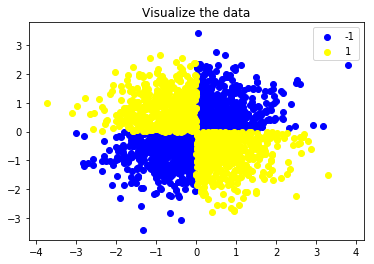

In [13]:
"""
Integrage the above functions

Load and pre-processing the data

"""

if __name__ == '__main__':
    # Load data
    df = pd.read_csv("hw2data.csv",header=None)
    df.columns = ['x1','x2','y']
    n,p = df.shape

    # Visualize the data

    plt.scatter(df[df['y'] == -1.0]['x1'],df[df['y'] == -1.0]['x2'], label="-1",color = 'blue')
    plt.scatter(df[df['y'] == 1.0]['x1'],df[df['y'] == 1.0]['x2'], label="1", color = 'yellow')
    plt.legend()
    plt.title("Visualize the data")
    plt.savefig("h2_svm_data")
    # Partition the data into training and testing sets

    # Training: first 80%; Testing: last 20%
    df_train = df.iloc[0:int(0.8*n),:]
    df_test = df.iloc[-int(0.2*n):,:]

In [ ]:
"""Use training data to perform k=10-fold cross validation"""
"""Training"""
if __name__ == '__main__':
    # Random shuffle and split data
    np.random.seed(1)
    df_train = df_train.sample(frac=1)
    k = 10
    df_splitted = np.split(df_train,k,axis = 0)

    Err_train = []
    Err_valid = []

    C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000] 

    for c in C:
        err_train = []
        err_valid = []

        for i in range(k):
            X_valid, y_valid, X_train, y_train = get_train_valid(df_splitted, i, k)

            # Train model
            w,b0 = svmfit(X_train=X_train,Y_train=y_train,C=c)

            # get train and valid error
            y_predict_train = predict(w=w,b0=b0,X=X_train)
            err = np.sum((np.array(y_train).reshape(-1,1) != y_predict_train)*1)
            err_train.append(err/len(y_predict_train))

            y_predict_valid = predict(w=w,b0=b0,X=X_valid)
            err = np.sum((np.array(y_valid).reshape(-1,1) != y_predict_valid)*1)
            err_valid.append(err/len(y_predict_valid))

        Err_train.append(np.average(err_train))
        Err_valid.append(np.average(err_valid))

In [ ]:
"""Testing"""
if __name__ == '__main__':
    X_test, y_test = df_test.iloc[:,0:2], df_test.iloc[:,2]

    Err_test = []
    for c in C:
        w_test, b0_test = svmfit(X_train=X_test,Y_train=y_test,C=c)
        y_predict_test = predict(w=w_test, b0=b0_test,X = X_test)
        err_test = np.sum(np.array(y_test).reshape(-1,1) == y_predict_test) * 1
        Err_test.append(err_test/len(y_predict_test))

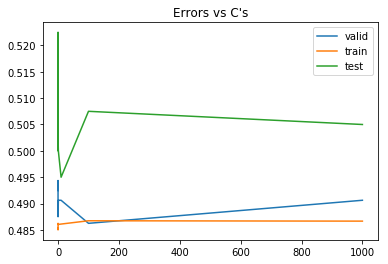

In [25]:
"""Plotting errors w.r.t. values of C"""
if __name__ == '__main__':
    # Scaling the errors into one level
    #Err_train1 = [Err_train[i]/9 for i in range(len(Err_train))]
    #Err_test1 = [Err_test[i]/(400/160) for i in range(len(Err_test))]
    
    
    
    plt.plot(C,Err_valid,label='valid')
    plt.plot(C,Err_train,label='train')
    plt.plot(C,Err_test,label='test')
    plt.legend()
    plt.title("Errors vs C's")
    plt.savefig("h2_svm_errors")